# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. In particular, our model will be fed a text query and will return several images that are related to the query. To do this task, our model will be trained so that it embeds both image and text data into the same space, and importantly, encodes relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function. <br>
<br>
In this notebook, I develop the evaluation metrics, median rank (**MedR**) and recall rate at top K (**R@K**). <br>
<br>
In the test phase, we first project all the test images into the embedding space via the image encoder. For each test (image, text) pair, we consider the text as a query, which is also mapped into the embedding space through the text encoder. Then, we rank all the test images by the similarity to the query. The **MedR** is the median of the rank of the true image over all the test data. So, smaller **MedR** indicates that the model works well. In **R@K**, we take only top K images for each query and check if the true image is included. By doing this check for all test data, we can calculate the probability that the true image is successfully retrieved. Thus, higher **R@K** is better.

### Intuition behind the CosineEmbeddingLoss
https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html<br>
$$\text{loss}(x,y) = \begin{cases} 1-\cos(x_{image}, x_{text}) & \text{if } y=1 \\ \max(0, \cos(x_{image}, x_{text})- \text{margin}) & \text{if } y=-1 \end{cases}$$
Let $d$ be the dimensionality of the embedding space. When negative pair $(x^-, -1)$ is given, we want to map $x_{image}, x_{text}$ in distant place. One might think that having $\cos(x_{image}, x_{text}) = -1$ is ideal, but given $x_{image}$, there is only one vector (up to scaling) in the embedding space that satisfies it. Since we have many vectors that are separated each other, forcing all the pairs of them having cosine similarity (nearly) $-1$ is impossible. <br>
By contrast, forcing them having cosine similarity (nearly) $0$ is possible. In other words, forcing them being (nearly) orthogonal is possible. Nearly orthogonal is defined as the normalized dot product is $0$ with a small error term $\epsilon > 0$. That is, 
$$-\epsilon \leq \frac{\langle x_i, x_j \rangle}{\lVert x_i \rVert_2 \lVert x_j \rVert_2} \leq \epsilon$$
While there are only $d$ mutually orthogonal vectors in $d$ dimensional space, there exists $2^{\Theta(\epsilon^2 d)}$ mutually nearly orthogonal vectors. Thus, our goal is to train encoders so that negative inputs are mapped as nearly orthogonal. In this context, it makes sense not to penalize so long as cosine similarity is negative, and moreover, allow a small margin to let vectors nearly orthogonal, not strictly orthogonal. <br>
Note that for positive pairs, this loss function enforces them to having cosine similarity $1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

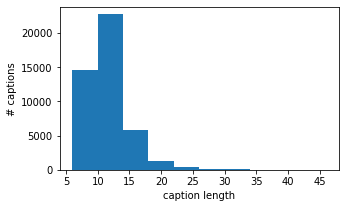

Shortest caption length: 6
Longest caption length: 46
The maximum sentence length for the text encoder is set to 46.


In [5]:
text_len = [len(s.split()) for s in dataset["texts"]]
plt.figure(figsize=(5,3))
plt.xlabel("caption length")
plt.ylabel("# captions")
plt.hist(text_len)
plt.show()
print("Shortest caption length: " + str(min(text_len)))
print("Longest caption length: " + str(max(text_len)))

max_len = 55 # BERT tokenizer is not one word per one embedding.
print("The maximum sentence length for the text encoder is set to " + str(max_len) + ".")

In [6]:
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
# Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class DualEncoderDataset(Dataset):
    def __init__(self, images, texts, neg_rate=4):
        # This class assumes that num_image < num_texts, and the number of texts per image is the same for all images.
        self.imagedata = images
        self.textdata = texts
        self.num_images = len(images)
        self.num_texts = len(texts)
        self.image_text_rate = int(self.num_texts / self.num_images)
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()
    
    def shuffle(self):
        self.random_map = np.random.randint(0, self.num_texts - self.image_text_rate, self.num_negative)
        for i in range(self.num_negative):
            if self.random_map[i] >= i % self.num_texts // self.image_text_rate * self.image_text_rate:
                self.random_map[i] += self.image_text_rate
    
    def __len__(self):
        return self.num_texts + self.num_negative

    def __getitem__(self, sample_idx):
        if torch.is_tensor(sample_idx):
            sample_idx = sample_idx[0].tolist()
        image_idx = sample_idx % self.num_texts // self.image_text_rate
        if sample_idx < self.num_texts:
            text_idx = sample_idx
        else:
            text_idx = self.random_map[sample_idx - self.num_texts]
        sample = {"images": self.imagedata[image_idx], "texts": self.textdata[text_idx], "labels": int(sample_idx < self.num_texts) * 2 - 1}
        return sample

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type)

The device is cuda


In [13]:
import torchvision
!pip install transformers
from transformers import BertModel, BertTokenizerFast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 46.2 MB/s 
     |████████████████████████████████| 7.6 MB 56.0 MB/s 
     |████████████████████████████████| 182 kB 77.7 MB/s 


In [58]:
class Incep3Encoder(torch.nn.Module):
    def __init__(self, embed_dim):
        super(Incep3Encoder, self).__init__()

        self.incep3 = torchvision.models.inception_v3(pretrained=True)
        self.incep3.aux_logits = False # We don't use the auxiliary output.
        for parameter in self.incep3.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.incep3.fc = torch.nn.Sequential(
            torch.nn.Linear(self.incep3.fc.in_features, 512), # in_features=2048 in Inception V3.
            torch.nn.ReLU(),
            torch.nn.Linear(512, embed_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        return self.incep3(x)

class BertEncoder(torch.nn.Module):
    def __init__(self, embed_dim):
        super(BertEncoder, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=False) # With bert-base-uncased, all the input are lowercased before being tokenized.
        for parameter in self.bert.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(self.bert.config.hidden_size, 512), # hidden_size=768.
            torch.nn.ReLU(),
            torch.nn.Linear(512, embed_dim),
            torch.nn.Tanh()
        )
    
    def forward(self, input_ids, attention_mask):
        last_hidden, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        return self.fc(last_hidden[:, 0])

def Encoder(name, embed_dim=128):
    if name == "InceptionV3":
        return Incep3Encoder(embed_dim)
    elif name == "BERT":
        return BertEncoder(embed_dim)
    else:
        raise ValueError(name + " has not been implemented!")

def printParameters(encoder="all"):
    print("\n")
    if encoder in ["image", "all"]:
        image_enc_total_params = 0
        image_enc_trainable_params = 0
        for parameter in image_enc.parameters():
            image_enc_total_params += np.prod(parameter.size())
            if parameter.requires_grad:
                image_enc_trainable_params += np.prod(parameter.size())
        print(f"=== Image Encoder ===")
        print(f"  Total Parameters: {image_enc_total_params:,}")
        print(f"  Trainable Parameters: {image_enc_trainable_params:,}\n")
    if encoder in ["text", "all"]:
        text_enc_total_params = 0
        text_enc_trainable_params = 0
        for parameter in text_enc.parameters():
            text_enc_total_params += np.prod(parameter.size())
            if parameter.requires_grad:
                text_enc_trainable_params += np.prod(parameter.size())
        print(f"=== Text Encoder ===")
        print(f"  Total Parameters: {text_enc_total_params:,}")
        print(f"  Trainable Parameters: {text_enc_trainable_params:,}\n")

In [50]:
class ImagePreprocessor():
    def process(self, x):
        return torch.swapaxes(torch.swapaxes(x, 3, 2), 2, 1)

class BertPreprocessor():
    def __init__(self, max_len=50):
        self.max_len = max_len
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", model_max_length=self.max_len)
    
    def process(self, x):
        padded_list = self.tokenizer.batch_encode_plus(x, padding=True)
        input_ids = torch.LongTensor(np.array(padded_list["input_ids"])) # It looks like bypassing numpy is faster.
        attention_mask = torch.LongTensor(np.array(padded_list["attention_mask"]))
        return input_ids, attention_mask

def Preprocessor(name, max_len=50):
    if name in ["InceptionV3"]:
        return ImagePreprocessor()
    elif name in ["BERT"]:
        return BertPreprocessor(max_len)
    else:
        raise ValueError(name + " has not been implemented!")

In [59]:
embed_dim = 100
image_model = "InceptionV3"
text_model = "BERT"

image_enc = Encoder(image_model, embed_dim).to(device)
text_enc = Encoder(text_model, embed_dim).to(device)
printParameters()

image_proc = Preprocessor(image_model)
text_proc = Preprocessor(text_model, max_len)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




=== Image Encoder ===
  Total Parameters: 26,212,652
  Trainable Parameters: 1,100,388

=== Text Encoder ===
  Total Parameters: 109,927,268
  Trainable Parameters: 445,028



In [17]:
criterion = torch.nn.CosineEmbeddingLoss(margin=0.1) # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_enc.parameters(), lr=0.001)
text_optimizer = torch.optim.Adam(text_enc.parameters(), lr=0.001)

In [18]:
def train():
    image_enc.train()
    text_enc.train()
    train_loss = 0
    n_samples = 0

    for batch in trainloader:
        image_batch = image_proc.process(batch["images"]).to(device)
        text_batch, attention_batch = text_proc.process(batch["texts"])
        text_batch = text_batch.to(device)
        if attention_batch is not None:
            attention_batch = attention_batch.to(device)
        label_batch = torch.LongTensor(np.array(batch["labels"])).to(device)

        image_optimizer.zero_grad()
        text_optimizer.zero_grad()
        image_embedding = image_enc(image_batch)
        if attention_batch is not None:
            text_embedding = text_enc(text_batch, attention_batch)
        else:
            text_embedding = text_enc(text_batch)
        loss = criterion(image_embedding, text_embedding, label_batch)
        loss.backward()
        image_optimizer.step()
        text_optimizer.step()

        train_loss += loss.item()
        n_samples += label_batch.size(0)

    train_loss /= n_samples
    return train_loss

def eval():
    image_enc.eval()
    text_enc.eval()
    eval_loss = 0
    n_samples = 0
    with torch.no_grad():
        for batch in testloader:
            image_batch = image_proc.process(batch["images"]).to(device)
            text_batch, attention_batch = text_proc.process(batch["texts"])
            text_batch = text_batch.to(device)
            if attention_batch is not None:
                attention_batch = attention_batch.to(device)
            label_batch = torch.LongTensor(np.array(batch["labels"])).to(device)

            image_embedding = image_enc(image_batch)
            if attention_batch is not None:
                text_embedding = text_enc(text_batch, attention_batch)
            else:
                text_embedding = text_enc(text_batch)
            loss = criterion(image_embedding, text_embedding, label_batch)

            eval_loss += loss
            n_samples += label_batch

    eval_loss /= n_samples
    return eval_loss

def test():
    image_enc.eval()
    text_enc.eval()
    image_mapped = []
    # Under construction!

In [19]:
epochs = 10
batch_size = 128

train_loss = []

print("Start Training...")
for epoch in range(epochs):
    if (epoch + 1) % 2 == 0:
        print("\nEpoch: " + str(epoch + 1))
    trainloader = DataLoader(DualEncoderDataset(train_images, train_texts, neg_rate=2), 
                             batch_size=batch_size, 
                             shuffle=True)
    loss = train()
    train_loss.append(loss)

Start Training...


Token indices sequence length is longer than the specified maximum sequence length for this model (53 > 46). Running this sequence through the model will result in indexing errors



Epoch: 2


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1, epochs + 1), train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()